# Анализ покупок в мини-пекарне

ЗАДАЧА:
<br>Оценить полноту и качество данных
<br>Выяснить какие поведенческие факторы влияют на количество линий в чеке, где можно приложить усилия для увеличения длинны чека.

ОПИСАНИЕ ДАТАСЕТА:
<br>TransactionNo	- номер транзакции, все строки одного заказа (чека) под одним номером
<br>Items - товар
<br>DateTime - дата транзакции
<br>Daypart - время дня транзакции
<br>Weekend - флаг буднего или выходного дня



## Загрузка, просмотр и предобработка данных

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as st
from scipy.stats import norm
import statsmodels.api as sm
import pylab
from tqdm.auto import tqdm

pio.templates.default = "simple_white"
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
cm = sns.light_palette("brown", as_cmap=True)
plt.style.use('dark_background')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Загрузка датасета
df = pd.read_csv('https://onedrive.live.com/download?cid=BB74A734D466EB21&resid=BB74A734D466EB21%218133&authkey=AGML8Qf66L77urA')

In [3]:
df.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionNo  20507 non-null  int64 
 1   Items          20507 non-null  object
 2   DateTime       20507 non-null  object
 3   Daypart        20507 non-null  object
 4   DayType        20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


In [5]:
# Перевод столбца с датой в формат даты и выделение дня, месяца и часа
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Day'] = df['DateTime'].astype('datetime64[D]')
df['Month'] = df['DateTime'].astype('datetime64[M]')
df['Dayname'] = df['DateTime'].dt.day_name()
df['Hour'] = df['DateTime'].dt.hour
df.head()

,TransactionNo,Items,DateTime,Daypart,DayType,Day,Month,Dayname,Hour
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend,2016-10-30,2016-10-01,Sunday,9
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend,2016-10-30,2016-10-01,Sunday,10
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend,2016-10-30,2016-10-01,Sunday,10
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend,2016-10-30,2016-10-01,Sunday,10
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend,2016-10-30,2016-10-01,Sunday,10


In [6]:
# Вывод начала периода
df['DateTime'].min()

Timestamp('2016-01-11 07:51:20')

In [7]:
# Вывод конца периода
df['DateTime'].max()

Timestamp('2017-12-03 16:28:00')

In [8]:
# Количество дней в 
df['Day'].nunique()


159

In [9]:
# Количество дней для каждого месяца для которых есть данные в выборке
df.groupby('Month').agg({'Day':'nunique'}).reset_index()

,Month,Day
0,2016-01-01,2
1,2016-02-01,2
2,2016-03-01,2
3,2016-04-01,2
4,2016-05-01,2
5,2016-06-01,2
6,2016-07-01,2
7,2016-08-01,2
8,2016-09-01,2
9,2016-10-01,4


In [10]:
# Полнота данных в разрезе времени суток
df.groupby(['DayType', 'Daypart']).agg({'Day':'nunique'})

Day
DayType Daypart       
Weekday Afternoon  113
        Evening     73
        Morning    113
        Night        2
Weekend Afternoon   45
        Evening     21
        Morning     46
        Night        2

In [11]:
# День Weekend с отсутствием данных по Afternoon
temp = df.query('DayType == "Weekend"').groupby(['Day', 'Daypart']).agg({'Day':'nunique'}).rename(columns={'Day':'Ndays'}).reset_index()
temp.groupby('Day').agg({'Ndays':'sum'}).query('Ndays == 1')

,Ndays
Day,
2017-01-01,1


In [12]:
df = df.query('Daypart not in ["Evening", "Night"] and Day != "2017-01-01"')

**Вывод: Временной период данных не полный, присутствуют разное количество дней для каждого месяца. Количество дней с наличием данных по Morning и Afternoon совпадает с количеством уникальных дней. Данные по Evening и Night присутствуют не в каждом дне. Данные за утро и день пригодны для анализа, как наиболее полные.**

---



## EDA

### Распределение чеков в динамике временного периода

In [13]:
# Группировка уникальных чеков по дням
day_grouped = df.groupby('Day').agg({'TransactionNo':'nunique'}).reset_index()

In [14]:
# Cтатистики распределения уникальных чеков
day_grouped.describe()

,TransactionNo
count,158.000000
mean,58.170886
std,17.188054
min,23.000000
25%,46.000000
50%,53.000000
75%,68.000000
max,118.000000


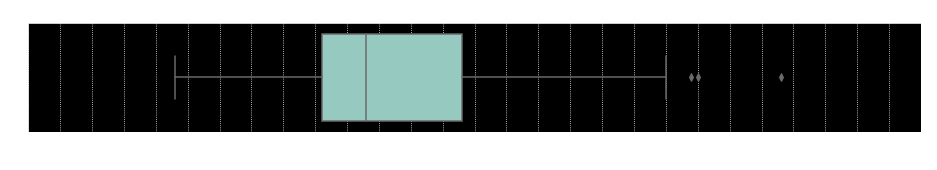

In [15]:
# График распределения количества чеков по времени суток
fig, ax = plt.subplots(figsize=(16, 2))
sns.boxplot(x=day_grouped['TransactionNo'])
plt.title('Распределение количества чеков')
ax.set_xticks(np.arange(0,145,5))
plt.xlabel('количество чеков в день')
plt.ylabel('частота')
plt.show()

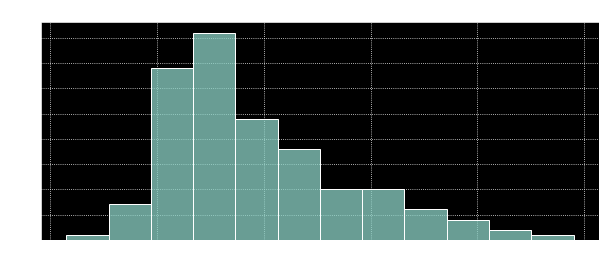

In [16]:
# График распределения количества чеков по дням
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(day_grouped['TransactionNo'])
plt.title('Распределение количества чеков по дням')
plt.xlabel('количество в день')
plt.ylabel('количество дней')
plt.show()

**Только в четверти дней количество чеков менее 46, половина - в диапазоне от 46 до 68. Необычных дней когда количество чеков вдвое превышает среднее т.е. 58 всего несколько. В эти дни возможно влияние сторонних факторов на траффик посетителей**

---



### Распределение чеков по времени суток

In [17]:
# Вывод долей заказов в разрезе времени суток
sortorder = ['Morning','Afternoon']
daypart = df.groupby('Daypart').agg({'TransactionNo':'nunique'}).reindex(sortorder).reset_index()
daypart['Share'] = daypart['TransactionNo'] / daypart['TransactionNo'].sum()
daypart.style.background_gradient(cmap=cm, subset=['Share']).format({'Share': "{:.2%}"})

,Daypart,TransactionNo,Share
0,Morning,4102,44.63%
1,Afternoon,5089,55.37%


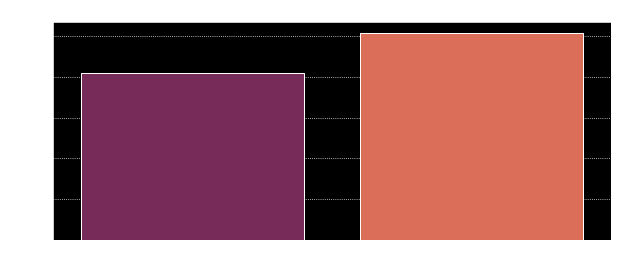

In [18]:
# График распределения количества чеков по времени суток
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x='Daypart', y='TransactionNo', data=daypart,  palette='rocket')
plt.title('Количество чеков в разрезе времени суток')
plt.xlabel('время суток')
plt.ylabel('количество чеков')
plt.show()

**Вывод: Большинство чеков приходятся на дневное время и утро, вечер и ночь - крайне незначительное число покупок и данные по вечеру и ночи есть не за каждый день, приоритетны для анализа соответственно периоды: утро и день**

---



### Распределение чеков по будням и выходным

In [19]:
# Вывод долей заказов по маркеру выходного и буднего дня
daytype = df.groupby('DayType').agg({'TransactionNo':'nunique'}).reset_index()
daytype['Share'] = daytype['TransactionNo'] / daytype['TransactionNo'].sum()
daytype.style.background_gradient(cmap=cm, subset=['Share']).format({'Share': "{:.2%}"})

,DayType,TransactionNo,Share
0,Weekday,5973,64.99%
1,Weekend,3218,35.01%


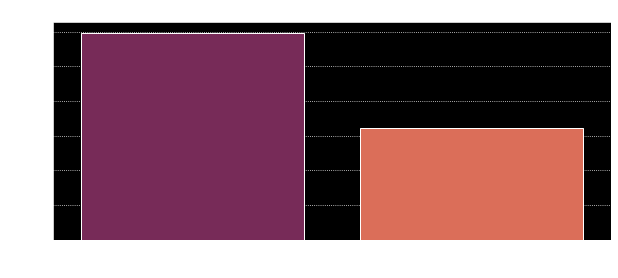

In [20]:
# График распределения количества чеков по времени суток
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x='DayType', y='TransactionNo', data=daytype,  palette='rocket')
plt.title('Количество чеков в разрезе выходного и буднего дня')
plt.ylabel('количество чеков')
plt.show()

**Вывод: Количество чеков в буднии немногим менее чем вдвое превышает количество чеков на выходных. Будние - главный драйвер продаж по количеству чеков**

---



### Распределение чеков по часам

In [21]:
# Вывод долей заказов в разрезе часов
hour = df.groupby(['Hour', "Daypart"]).agg({'TransactionNo':'nunique'}).reset_index()
hour['Share'] = hour['TransactionNo'] / hour['TransactionNo'].sum()
hour.style.background_gradient(cmap=cm, subset=['Share']).format({'Share': "{:.2%}"})

,Hour,Daypart,TransactionNo,Share
0,7,Morning,16,0.17%
1,8,Morning,375,4.08%
2,9,Morning,1006,10.95%
3,10,Morning,1266,13.77%
4,11,Morning,1439,15.66%
5,12,Afternoon,1325,14.42%
6,13,Afternoon,1143,12.44%
7,14,Afternoon,1120,12.19%
8,15,Afternoon,920,10.01%
9,16,Afternoon,581,6.32%


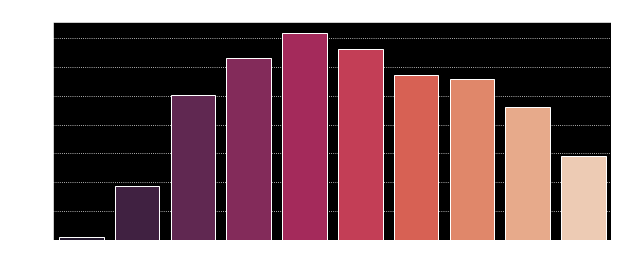

In [22]:
# График распределения количества чеков по часам
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x='Hour', y='TransactionNo', data=hour,  palette='rocket')
plt.title('Количество чеков в разрезе часов')
plt.xlabel('часы')
plt.ylabel('количество чеков')
plt.show()

**Вывод: Самый пиковый час с 11 до 12 утра, в целом большинство чеков с 9 до 16 часов, после 16 количество чеков падает сразу на треть**

---



### Количество чеков в разрезе продуктов

In [23]:
# Вывод количества заказов в разрезе продуктов, ТОП-10
item = df.groupby('Items').agg({'TransactionNo':'nunique'}).sort_values('TransactionNo', ascending=False).reset_index()
item['Share'] = item['TransactionNo'] / item['TransactionNo'].sum()
item.head(10).style.format({'Share': "{:.2%}"}).background_gradient(cmap=cm, subset=['Share']).format({'Share': "{:.2%}"})

,Items,TransactionNo,Share
0,Coffee,4453,24.22%
1,Bread,3045,16.56%
2,Tea,1305,7.10%
3,Cake,955,5.20%
4,Pastry,805,4.38%
5,Sandwich,676,3.68%
6,Medialuna,570,3.10%
7,Hot chocolate,530,2.88%
8,Cookies,495,2.69%
9,Brownie,372,2.02%


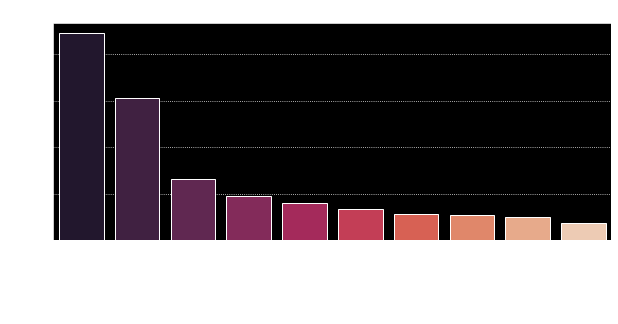

In [24]:
# График количества чеков в разрезе товаров
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x='Items', y='TransactionNo', data=item.head(10),  palette='rocket')
plt.title('Количество чеков в разрезе ТОП-10 товаров')
plt.xlabel('товары')
plt.ylabel('количество чеков')
plt.xticks(rotation=45)
plt.show()

**Вывод: Кофе и хлеб чаще всего встречаются в чеках, остальные товары заметно менее популярны, формат заведения скорее всего - булочная или мини-пекарня, где хлеб - основной товар**

---



### Распределение чеков по количеству строк

In [25]:
# Группировка по количеству строк в чеке
items_per_transaction = df.groupby('TransactionNo').agg({'Items':'count'}).reset_index()
items_per_transaction.columns = ['TransactionNo', 'ItemsNo']

In [26]:
# Добавление столбца с количество строк в чеке в датасет
df = pd.merge(df, items_per_transaction, on='TransactionNo')

In [27]:
# Распределение долей по количеству строк в чеке
line_num = pd.DataFrame(df['ItemsNo'].value_counts(normalize=True))
line_num.rename(columns={'ItemsNo':'line_share'}, inplace=True)
line_num.style.format({'line_share':"{:.2%}"}).background_gradient(
            cmap=cm)

,line_share
2,28.41%
3,22.56%
1,17.47%
4,16.68%
5,8.31%
6,3.88%
7,1.26%
8,0.84%
9,0.32%
11,0.22%


In [28]:
# Вывод долей заказов в разрезе времени суток в % 
daypart_items_qty = df.groupby(['Daypart', 'ItemsNo']).agg({'TransactionNo':'nunique'})
daypart_items_qty['Share'] = daypart_items_qty['TransactionNo'] / daypart_items_qty.groupby('Daypart')['TransactionNo'].sum()
daypart_items_qty.sort_values(['Daypart','TransactionNo'], ascending=False).reset_index().style.format({'Share': "{:.2%}"}).background_gradient(
            cmap=cm, subset=['Share']).background_gradient(cmap=cm, subset=['ItemsNo'])

,Daypart,ItemsNo,TransactionNo,Share
0,Morning,1,1660,40.47%
1,Morning,2,1299,31.67%
2,Morning,3,662,16.14%
3,Morning,4,320,7.80%
4,Morning,5,111,2.71%
5,Morning,6,37,0.90%
6,Morning,7,6,0.15%
7,Morning,8,4,0.10%
8,Morning,9,2,0.05%
9,Morning,10,1,0.02%


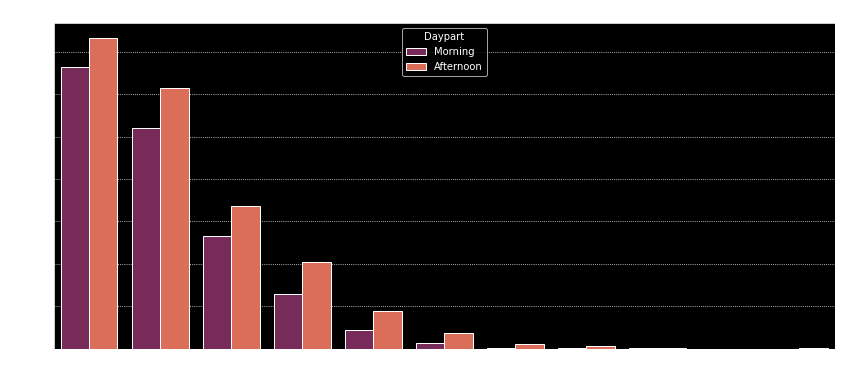

In [29]:
# График количества линий в чеке в разрезе времени суток
order_dpart = ['Morning', 'Afternoon']
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(
    x='ItemsNo', y='TransactionNo',  hue ='Daypart', hue_order = order_dpart, data=daypart_items_qty.reset_index(), palette='rocket')
plt.title('Распределение количества линий в разрезе времени суток')
plt.xlabel('количество линий в чеке')
plt.ylabel('количество чеков')
plt.show()

Вывод: Чеков с 2 и 3 покупками - половина, около трех четвертей чеков имеют от 1 до 4 покупок. Больше 80% чеков имеют от 1 до 5 строк (линий), днем меньше доля дневных чеков с 1 покупкой, но большая доля чеков с 4 строками, по сравнению с утром. Люди охотнее увеличивают чек днем, т.е. покупают больше позиций.

### Распределение чеков в зависимости от наличия в нем кофе

In [30]:
# Добавление флага наличия кофе в чеке в каждую линию(транзакцию) под одним номером
coffee_index = df.index[df['Items'] == 'Coffee'].to_list()
coffee_transactions = list(set(df.query('index in @coffee_index')['TransactionNo']))
df['coffee_flag'] = np.where(df['TransactionNo'].isin(coffee_transactions), 1, 0)

In [31]:
# Группировка чеков с кофе по количеству и долям в разрезе количеств линий и времени суток
with_coffee = df.query('coffee_flag == 1').groupby(['Daypart', 'ItemsNo']).agg({'TransactionNo':'nunique'})
with_coffee['Share'] = with_coffee['TransactionNo'] / with_coffee.groupby('Daypart')['TransactionNo'].sum()

In [32]:
# Группировка чеков с кофе по количеству и долям в разрезе количеств линий и времени суток
no_coffee = df.query('coffee_flag == 0').groupby(['Daypart', 'ItemsNo']).agg({'TransactionNo':'nunique'})
no_coffee['Share'] = no_coffee['TransactionNo'] / no_coffee.groupby('Daypart')['TransactionNo'].sum()

In [33]:
# Объеднинение группировок с кофе и без
coffee_diff = pd.merge(with_coffee, no_coffee, on=['Daypart', 'ItemsNo'])
coffee_diff.columns = ['coffee_orders_qty', 'coffee_orders_share', 'no_coffee_orders_qty', 'no_coffee_orders_share']
coffee_diff['diff'] = coffee_diff['no_coffee_orders_share'] - coffee_diff['coffee_orders_share']
coffee_diff.reset_index().style.background_gradient(
            cmap=cm, subset=['diff']).format({'coffee_orders_share': "{:.2%}",'no_coffee_orders_share': "{:.2%}",'diff': "{:.2%}"})

,Daypart,ItemsNo,coffee_orders_qty,coffee_orders_share,no_coffee_orders_qty,no_coffee_orders_share,diff
0,Afternoon,1,438,18.72%,1391,50.60%,31.88%
1,Afternoon,2,740,31.62%,798,29.03%,-2.60%
2,Afternoon,3,526,22.48%,314,11.42%,-11.06%
3,Afternoon,4,350,14.96%,163,5.93%,-9.03%
4,Afternoon,5,170,7.26%,51,1.86%,-5.41%
5,Afternoon,6,67,2.86%,25,0.91%,-1.95%
6,Afternoon,7,26,1.11%,4,0.15%,-0.97%
7,Afternoon,8,16,0.68%,1,0.04%,-0.65%
8,Afternoon,9,4,0.17%,1,0.04%,-0.13%
9,Afternoon,11,3,0.13%,1,0.04%,-0.09%


In [34]:
data = coffee_diff.reset_index()

# График распределения количества чеков по числу линий и наличию кофе в чеке
fig = go.Figure(
    data=[
        go.Bar(
            name="With coffee",
            x=data["ItemsNo"],
            y=data["coffee_orders_qty"],
            marker=dict(color='#b84242'),
            customdata = np.stack((data['Daypart'], data['coffee_orders_share']), axis=-1),
            hovertemplate='<br>%{customdata[1]:.2%}<br>из %{customdata[0]} чеков с %{x}<br>Кол-во чеков: %{y}'  
        ),    
        go.Bar(
            name="No coffee",
            x=data["ItemsNo"],
            y=data["no_coffee_orders_qty"],
            marker=dict(color='#a95aaa'),
            customdata = np.stack((data['Daypart'], data['no_coffee_orders_share']), axis=-1),
            hovertemplate='<br>%{customdata[1]:.2%}<br>из %{customdata[0]} чеков с %{x}<br>Кол-во чеков: %{y}'   
        )
    ],
    layout=go.Layout(
        title="Количество заказов по числу линй в чеке с кофе и без",
        yaxis_title="Количество чеков",
        xaxis_title="Количество линий в чеке",
    )
)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        ticktext = ['1 line', '2 lines', '3 lines', '4 lines', '5 lines', '6 lines', '7 lines', '8 lines', '9 lines', '10 lines', '11 lines']
    )
)
fig.update_layout(legend = dict(bgcolor = 'rgba(0,0,0,0)'))
fig.show()

Вывод: При сравнении долей чеков с кофе и без по времени суток, видно что в чеках с кофе уменьшается доля чеков с одной покупкой и увеличивается доля чеков с 3 - 4 строками, в утренних заказах чуть более увеличивается доля чеков с 3 строками, в дневных с 4. Если люди заказывают кофе, то берут что-то еще, особенно в дневные часы. Кофе - якорный товар для покупок остального ассортимента. Возможно кофе и позиции к кофе берут с собой либо есть возможность выпить его на месте. Если стимулировать покупку кофе то будет расти продажи остальных позиций.

## Проверка гипотез

### Функции для оценки распределения значений и средних в выборках и проверки гипотиз

Проверка статистических гипотез будет производится:

1. C помощью параметрического Т-теста 
2. С помощью непараметрического тетса Манна-Уитни
3. C помощью бутстрапирования выборок

Для соблюдения требований Т-теста будет оцениватся распределение значений и их средних, проверятся гипотеза о равенстве дисперсий.

In [35]:
# Функция визуализации распределения значений  либо средних значений в двух выборках
def dist_evaluation(
    groupA, # выборка А
    groupB, # выборка Б
    title_name, # наименование визуализации
    sub_title_a, # титул выборки А
    sub_title_b # титул выборки Б
):

  fig, axes = plt.subplots(2, 2, figsize=(14, 8))
  fig.suptitle(title_name)
  sns.set_palette("rocket_r", 2, .85  ,color_codes=True)
  sns.histplot(groupA, ax=axes[0,0], kde=False, bins=10)
  axes[0,0].set_title(sub_title_a)
  axes[0,0].set_xlabel('кол-во строк чека')
  axes[0,0].set_ylabel('частота')
  sns.histplot(groupB, ax=axes[0,1], kde=False, bins=10)
  axes[0,1].set_title(sub_title_b)
  axes[0,1].set_xlabel('кол-во строк чека')
  axes[0,1].set_ylabel('частота')
  qqplot(groupA, line='s', ax=axes[1,0])
  qqplot(groupB, line='s', ax=axes[1,1])
  plt.show()

In [36]:
# Функция теста Левене на проверку равенства дисперсий
def levene_test(groupA, groupB, alpha_level):

  alpha = alpha_level
  results = st.levene(a_with_coffee['ItemsNo'], b_no_coffee['ItemsNo'])
  print('p-значение:', results.pvalue)

  if (results.pvalue < alpha):
      print("Необходимо отвергнуть нулевую гипотезу о равенстве дисперсий популяций из которых взяты выборки")
  else:
      print("Не нужно отвергать нулевую гипотезу о равенстве дисперсий популяций из которых взяты выборки")

In [37]:
# Функция Т теста в модификации Уэлча
def t_test(groupA, groupB, alpha_level):

  alpha = alpha_level
  results = st.ttest_ind(a_with_coffee['ItemsNo'], b_no_coffee['ItemsNo'], equal_var=False) 
  print('p-значение:', results.pvalue)

  if (results.pvalue < alpha):
      print("Необходимо отвергнуть нулевую гипотезу")
  else:
      print("Не нужно отвергать нулевую гипотезу")

In [38]:
# Функция теста Манна-Уитни
def test_mw(groupA, groupB, alpha_level):

  alpha = alpha_level
  results = st.mannwhitneyu(a_with_coffee['ItemsNo'], b_no_coffee['ItemsNo']) 
  print('p-значение:', results.pvalue)

  if (results.pvalue < alpha):
      print("Необходимо отвергнуть нулевую гипотезу")
  else:
      print("Не нужно отвергать нулевую гипотезу")

In [39]:
# Функция бутстрапирования
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it, # количество бутстрэп-подвыборок
    statistic, # интересующая нас статистика
    bootstrap_conf_level, # доверительный интервал
    alpha # уровень значимости
):
    pvalue = []
    boot_len = max([len(data_column_1), len(data_column_2)])#Количество сэмплов
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # складываем в список разницу между статистикой
    pd_boot_data = pd.DataFrame(boot_data) # пришем результаты в датафрейм
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.subplots(figsize=(10, 4))
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('blue')
            bar.set_edgecolor('black')
    plt.style.use('dark_background')
    plt.grid(color='w', linestyle='-', linewidth=0.3)
    plt.vlines(quants,ymin=0,ymax=65,linestyle='--', color='yellow')
    plt.xlabel('значение среднего разности двух выборок')
    plt.ylabel('частота')
    plt.title("Распределение средних разности между двумя выборками")
    plt.show()

    print('')   
    print('Вероятность попадания среднего разностей двух выборок в доверительный интервал при верной H0:', p_value, "\n")

    if (p_value < alpha):
        print("Необходимо отвергнуть нулевую гипотезу", "\n")
    else:
        print("Не нужно отвергать нулевую гипотезу", "\n")

    print('Границы доверительного интервала среднего разностей двух выборок', quants, "\n")
    
    print('Среднее разностей значений в исследуемой выборке', abs(data_column_1.mean() - data_column_2.mean()))

### Наличие кофе в чеке увеличивает количество строк в чеке

In [40]:
# Выборка чеков с кофе
a_with_coffee = df.query('coffee_flag == 1').groupby(
    'TransactionNo').agg({'ItemsNo':'mean'}).reset_index()
a_with_coffee['ItemsNo'] = a_with_coffee['ItemsNo'].astype(int)
a_with_coffee.head(2)   

,TransactionNo,ItemsNo
0,5,3
1,7,4


In [41]:
# Выборка чеков без кофе
b_no_coffee = df.query('coffee_flag == 0').groupby(
    'TransactionNo').agg({'ItemsNo':'mean'}).reset_index()
b_no_coffee['ItemsNo'] = b_no_coffee['ItemsNo'].astype(int)
b_no_coffee.head(2)

,TransactionNo,ItemsNo
0,1,1
1,2,2


In [42]:
# Группировка статистик по флагу наличия кофе в чеке
coffee_metrics = df.groupby('coffee_flag').agg({'TransactionNo':'nunique'}).reset_index()
coffee_metrics['Share'] = (coffee_metrics['TransactionNo'] / coffee_metrics['TransactionNo'].sum())*100
coffee_metrics

,coffee_flag,TransactionNo,Share
0,0,4738,51.55043
1,1,4453,48.44957


In [43]:
# Статистики групп с кофе и без
coffee_statistics = pd.merge(a_with_coffee['ItemsNo'].describe().to_frame(), b_no_coffee['ItemsNo'].describe().to_frame(),left_index=True, right_index=True)
coffee_statistics.columns=['with_coffee','no_coffee']
coffee_statistics

,with_coffee,no_coffee
count,4453.000000,4738.000000
mean,2.608803,1.763402
std,1.398283,1.041849
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,3.000000,2.000000
max,11.000000,11.000000


Среднее и медиана в чеках с кофе по выборке - больше чем в чеках без кофе, выборочное различие достаточно сильное

---



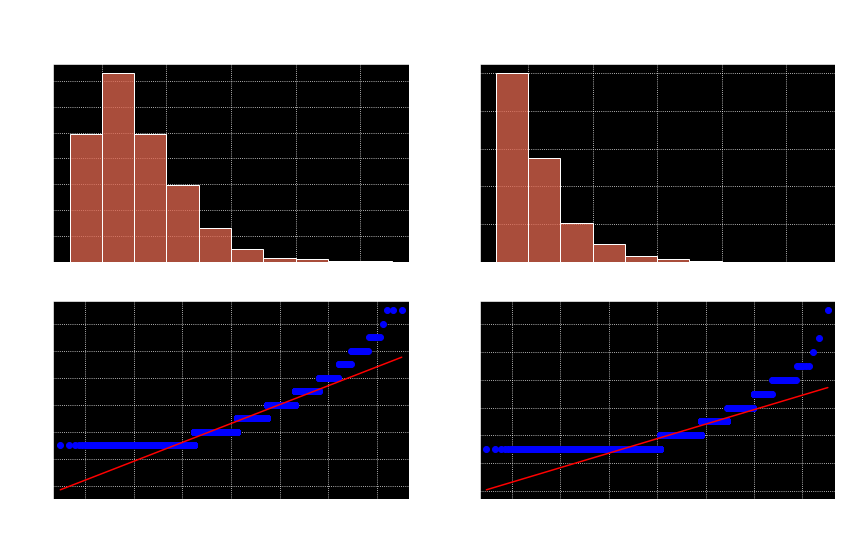

In [44]:
# Оценка распределения количества линий в чеках с кофе и без
dist_evaluation(
    a_with_coffee['ItemsNo'],
    b_no_coffee['ItemsNo'],
    'Распределение количества строк в чеке с кофе и без',
    'С кофе',
    'Без кофе'
)

Распределение количества строк в обоих группах довольно далеки от нормального, поэтому нужно проверить нормальность распределения средних, для этого можно использовать рандомное сэмплирование выборок с повторением значений.

In [45]:
# Получение ряда средних значений 1000 сэмплов в каждой группе
a1 = pd.Series([a_with_coffee['ItemsNo'].sample(4453, replace=True).mean() for _ in range(1000)])
b1 = pd.Series([b_no_coffee['ItemsNo'].sample(4453, replace=True).mean() for _ in range(1000)])

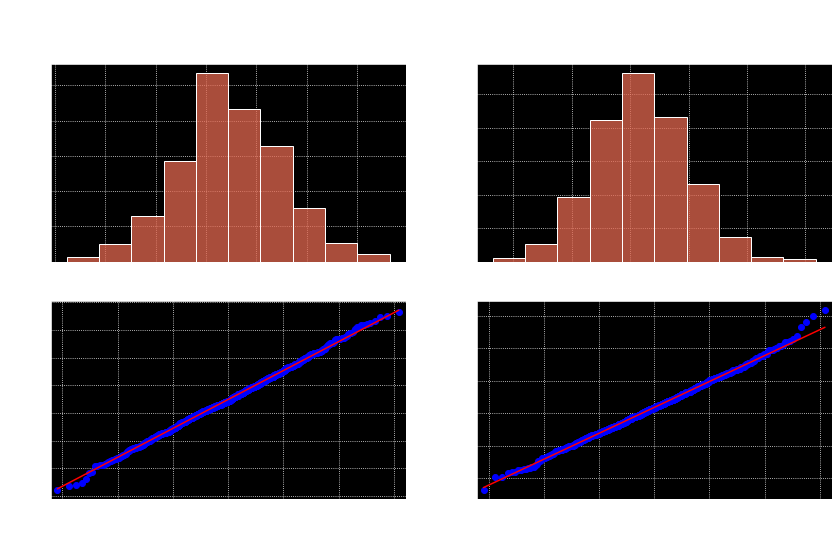

In [46]:
dist_evaluation(
    a1,
    b1,
    'Распределение среднего строк в чеке с кофе и без',
    'С кофе',
    'Без кофе')

Распределение самого значения количества строк в обоих выборках не похоже на нормальное, но распределение средних говорит о нормальности. Поэтому возможно применения теста Уэлча, после проверки одинаковости дисперсий тестом Левне, либо теста Манна-Уитни, который не предъявляет требований к нормальности распределения

***ГИПОТЕЗА***

<br>**H0** - среднее количество строк в чеках с кофе и без кофе не различаются
<br>**H1** - среднее количество строк в чеках с кофе и без кофе различаются

<br>Уровень статистической значимости - 0.05

In [47]:
# Проверка равенства дисперсий тестом Левене
levene_test(a_with_coffee['ItemsNo'], b_no_coffee['ItemsNo'], 0.05)

p-значение: 2.2943074543600556e-38
Необходимо отвергнуть нулевую гипотезу о равенстве дисперсий популяций из которых взяты выборки


Вероятность что дисперсии совокупностей из которых взяты выборки эквивалентны ничтожна, поэтому Т тест будет в модификации теста Уэлча, который подразумевает что дисперсии могут быть не равны

In [48]:
# Проверка гипотезы Т тестом для выборок с разной дисперсией
t_test(a_with_coffee['ItemsNo'], b_no_coffee['ItemsNo'], 0.05)

p-значение: 1.194160338308203e-220
Необходимо отвергнуть нулевую гипотезу


In [49]:
test_mw(a_with_coffee['ItemsNo'], b_no_coffee['ItemsNo'], 0.05)

p-значение: 6.197219842784843e-247
Необходимо отвергнуть нулевую гипотезу


  0%|          | 0/1000 [00:00<?, ?it/s]

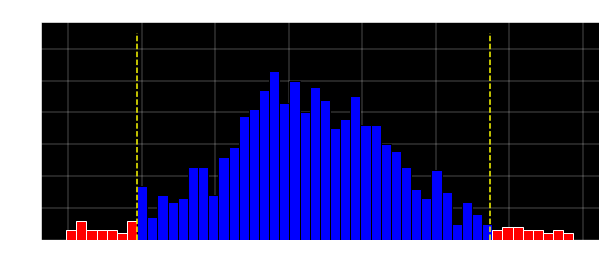


Вероятность попадания среднего разностей двух выборок в доверительный интервал при верной H0: 6.138734183540678e-262 

Необходимо отвергнуть нулевую гипотезу 

Границы доверительного интервала среднего разностей двух выборок               0
0.025  0.798639
0.975  0.894692 

Среднее разностей значений в исследуемой выборке 0.8454007746780148


In [50]:
# Проверка гипотезы бутстрепом
get_bootstrap(
    a_with_coffee['ItemsNo'], # числовые значения первой выборки
    b_no_coffee['ItemsNo'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # расчитываемая статистика
    bootstrap_conf_level = 0.95,
    alpha = 0.05 # уровень значимости
)

Вывод: оба статистических теста и бутстраприрование показали значимые статистические различия в количестве строк в чеках с кофе и без. Наличие кофе в чеке способствует увеличению покупок в чеке.

### Количество строк в чеке днем больше чем утром

In [51]:
# Выборка утренних чеков
a_morning = df.query('Daypart == "Morning"').groupby(
    'TransactionNo').agg({'ItemsNo':'mean', 'coffee_flag':'mean'}).reset_index()
a_morning[['ItemsNo', 'coffee_flag']] = a_morning[['ItemsNo', 'coffee_flag']].astype(int)
a_morning.head(2)

,TransactionNo,ItemsNo,coffee_flag
0,1,1,0
1,2,2,0


In [52]:
# Выборка дневных чеков
b_afternoon = df.query('Daypart == "Afternoon"').groupby(
    'TransactionNo').agg({'ItemsNo':'mean', 'coffee_flag':'mean'}).reset_index()
b_afternoon[['ItemsNo', 'coffee_flag']] = b_afternoon[['ItemsNo', 'coffee_flag']].astype(int)
b_afternoon.head(2)

,TransactionNo,ItemsNo,coffee_flag
0,43,2,0
1,44,2,1


In [53]:
# Группировка количества чеков по времени суток
daypart_metrics = df.groupby('Daypart').agg({'TransactionNo':'nunique'}).reset_index()
daypart_metrics['Share'] = (daypart_metrics['TransactionNo'] / daypart_metrics['TransactionNo'].sum())*100
daypart_metrics

,Daypart,TransactionNo,Share
0,Afternoon,5089,55.369383
1,Morning,4102,44.630617


In [54]:
# Статистики групп с кофе и без
daypart_statistics = pd.merge(a_morning['ItemsNo'].describe().to_frame(), b_afternoon['ItemsNo'].describe().to_frame(),left_index=True, right_index=True)
daypart_statistics.columns=['with_coffee','no_coffee']
daypart_statistics

,with_coffee,no_coffee
count,4102.000000,5089.000000
mean,2.048513,2.273335
std,1.172653,1.383073
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,10.000000,11.000000


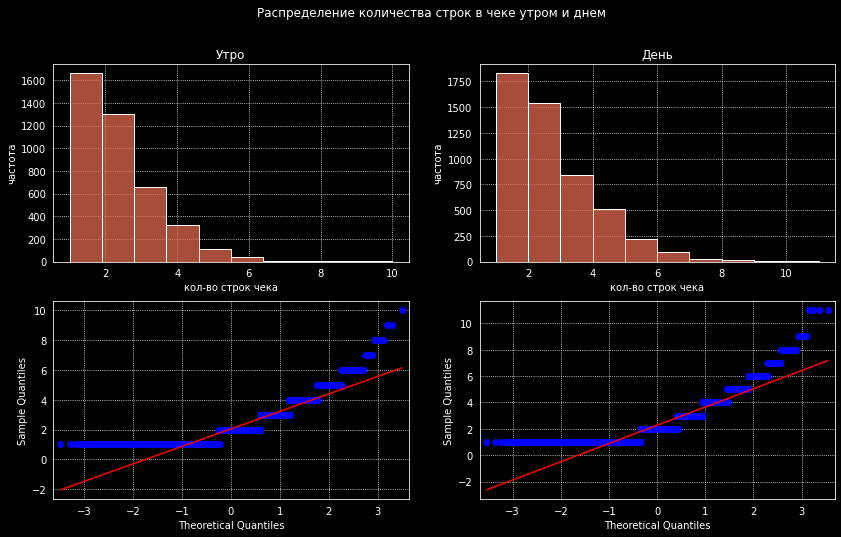

In [55]:
dist_evaluation(
    a_morning['ItemsNo'],
    b_afternoon['ItemsNo'],
    'Распределение количества строк в чеке утром и днем',
    'Утро',
    'День'
)

Распределение количества строк в утренней и вечерней выборке также не похоже на нормальное, поэтому нужно проверить распределение среднего выборок путем сэмплирования.

In [56]:
# Получение ряда средних значений 1000 сэмплов в каждой группе
a2 = pd.Series([a_morning['ItemsNo'].sample(4102, replace=True).mean() for _ in range(1000)])
b2 = pd.Series([b_afternoon['ItemsNo'].sample(5089, replace=True).mean() for _ in range(1000)])

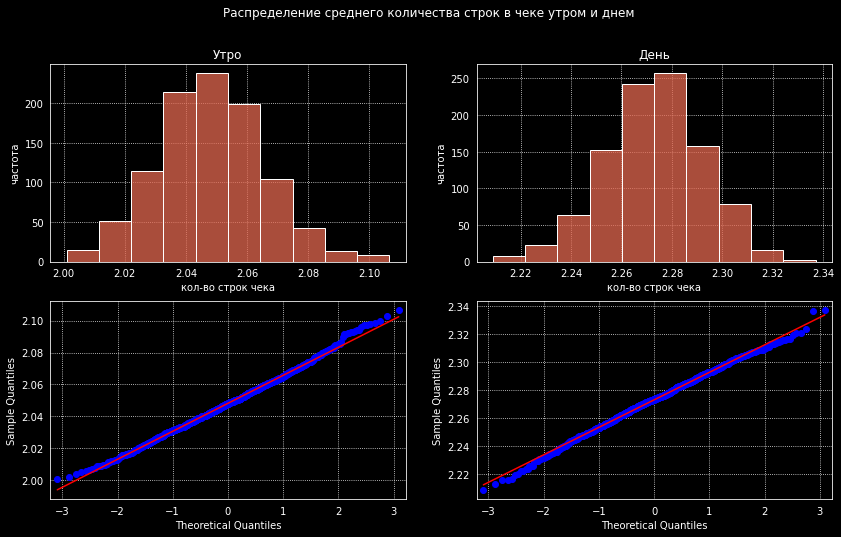

In [57]:
dist_evaluation(
    a2,
    b2,
    'Распределение среднего количества строк в чеке утром и днем',
    'Утро',
    'День'
)

Распределение средних в выборках после сэмплирования выглядит близко к нормальном. Возможно применение Т теста в модификации Уэлча, с параметром разности дисперсий, после проверки их тестом Левне.

Распределение средних в выборках после сэмплирования выглядит близко к нормальном. Возможно применение Т теста в модификации Уэлча, с параметром разности дисперсий, после проверки их тестом Левне.

***ГИПОТЕЗА***

<br>**H0** - среднее количество строк в чеках утром и днем не различаются
<br>**H1** - среднее количество строк в чеках утром и днем различаются

<br>Уровень статистической значимости - 95



In [58]:
# Проверка равенства дисперсий тестом Левене
levene_test(a_morning['ItemsNo'], b_afternoon['ItemsNo'], 0.05)

p-значение: 2.2943074543600556e-38
Необходимо отвергнуть нулевую гипотезу о равенстве дисперсий популяций из которых взяты выборки


Тест на эквивалентность дисперсий также показал статистические различия, поэтому Т тест в этом случае будет также с параметром qual_var=False

In [59]:
# Проверка гипотезы Т тестом для выборок с разной дисперсией
t_test(a_morning['ItemsNo'], b_afternoon['ItemsNo'], 0.05)

p-значение: 1.194160338308203e-220
Необходимо отвергнуть нулевую гипотезу


In [60]:
# Проверка гипотезы тестом Манна-Уитни
test_mw(a_morning['ItemsNo'], b_afternoon['ItemsNo'], 0.05)

p-значение: 6.197219842784843e-247
Необходимо отвергнуть нулевую гипотезу


  0%|          | 0/1000 [00:00<?, ?it/s]

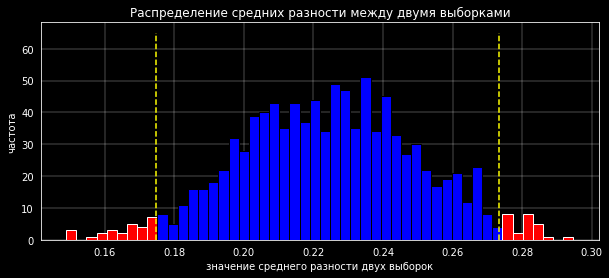


Вероятность попадания среднего разностей двух выборок в доверительный интервал при верной H0: 7.669071430218035e-19 

Необходимо отвергнуть нулевую гипотезу 

Границы доверительного интервала среднего разностей двух выборок               0
0.025  0.174887
0.975  0.273364 

Среднее разностей значений в исследуемой выборке 0.2248217228218259


In [61]:
# Проверка гипотезы бутстрепом
get_bootstrap(
    b_afternoon['ItemsNo'], # числовые значения первой выборки
    a_morning['ItemsNo'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # расчитываемая статистика
    bootstrap_conf_level = 0.95,
    alpha = 0.05 # уровень значимости
)

Вывод: оба статистических теста и бутстрапирование показали сильные статистические различия между средними количества чеков утром и днем. Дневные чеки имеют больше строк, люди покупают больше и увеличивают чек по количеству позиций в дневные часы.

### Количество линий в чеке с кофе днем больше чем утром

ГИПОТЕЗА


H0 - среднее количество строк в чеках с кофе утром и днем не различаются
<br>H1 - среднее количество строк в чеках с кофе утром и днем различаются


Уровень статистической значимости - 95

In [62]:
# Группировка утренних чеков по наличию кофе в чеке
morning_coffee = a_morning.groupby('coffee_flag').agg({'ItemsNo':['count','mean']}).reset_index()
morning_coffee.columns = ['coffee_flag', 'qty', 'lines_mean']
morning_coffee['share'] = morning_coffee['qty'] / morning_coffee['qty'].sum()
morning_coffee

,coffee_flag,qty,lines_mean,share
0,0,1989,1.665661,0.484885
1,1,2113,2.408897,0.515115


In [63]:
# Группировка дневных чеков по наличию кофе в чеке
afternoon_coffee = b_afternoon.groupby('coffee_flag').agg({'ItemsNo':['count', 'mean']}).reset_index()
afternoon_coffee.columns = ['coffee_flag', 'qty', 'lines_mean']
afternoon_coffee['share'] = afternoon_coffee['qty'] / afternoon_coffee['qty'].sum()
afternoon_coffee

,coffee_flag,qty,lines_mean,share
0,0,2749,1.834121,0.540185
1,1,2340,2.789316,0.459815


In [64]:
# Выборка утренних чеков с кофе
morning_coffee_lines = df.query('coffee_flag == 1 and Daypart == "Morning"').groupby(
    'TransactionNo').agg({'ItemsNo':'mean', 'coffee_flag':'mean'}).reset_index()
morning_coffee_lines[['ItemsNo', 'coffee_flag']] = morning_coffee_lines[['ItemsNo', 'coffee_flag']].astype(int)
morning_coffee_lines.sample(2)

,TransactionNo,ItemsNo,coffee_flag
1894,8680,3,1
1773,8167,2,1


In [65]:
# Выборка дневных чеков с кофе
afternoon_coffee_lines = df.query('coffee_flag == 1 and Daypart == "Afternoon"').groupby(
    'TransactionNo').agg({'ItemsNo':'mean', 'coffee_flag':'mean'}).reset_index()
afternoon_coffee_lines[['ItemsNo', 'coffee_flag']] = afternoon_coffee_lines[['ItemsNo', 'coffee_flag']].astype(int)
afternoon_coffee_lines.sample(2)

,TransactionNo,ItemsNo,coffee_flag
1046,4609,4,1
1473,6340,1,1


In [66]:
# Статистики групп с кофе утром и днем
daypart_coffee_lines_statistics = pd.merge(
    morning_coffee_lines['ItemsNo'].describe().to_frame(), afternoon_coffee_lines['ItemsNo'].describe().to_frame(),left_index=True, right_index=True)
daypart_coffee_lines_statistics.columns = ['morning_coffee','afternoon_coffee']
daypart_coffee_lines_statistics

,morning_coffee,afternoon_coffee
count,2113.000000,2340.000000
mean,2.408897,2.789316
std,1.263322,1.487174
min,1.000000,1.000000
25%,1.000000,2.000000
50%,2.000000,2.000000
75%,3.000000,4.000000
max,10.000000,11.000000


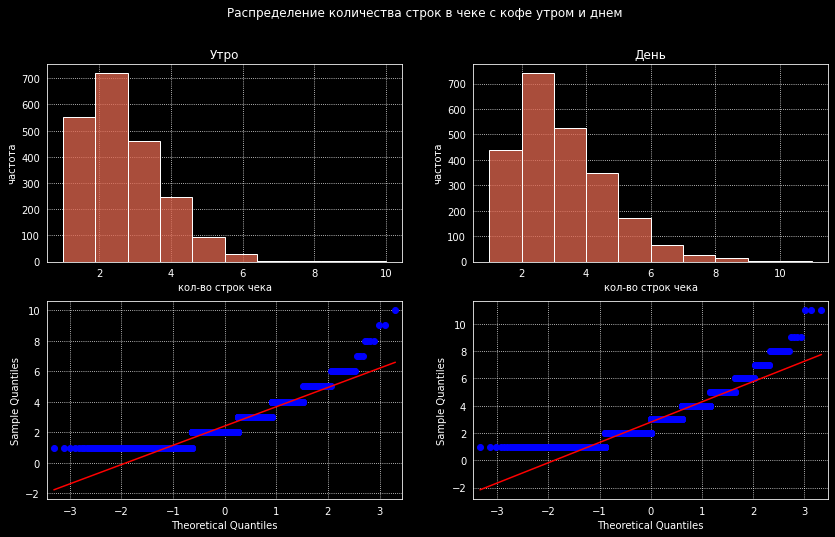

In [67]:
dist_evaluation(
    morning_coffee_lines['ItemsNo'],
    afternoon_coffee_lines['ItemsNo'],
    'Распределение количества строк в чеке с кофе утром и днем',
    'Утро',
    'День'
)

Распределение количества строк в утренней и вечерней выборке также не похоже на нормальное, поэтому нужно проверить распределение среднего выборок путем сэмплирования.

In [68]:
# Получение ряда средних значений 1000 сэмплов в каждой группе
a3 = pd.Series([a_morning['ItemsNo'].sample(2113, replace=True).mean() for _ in range(1000)])
b3 = pd.Series([b_afternoon['ItemsNo'].sample(2340, replace=True).mean() for _ in range(1000)])

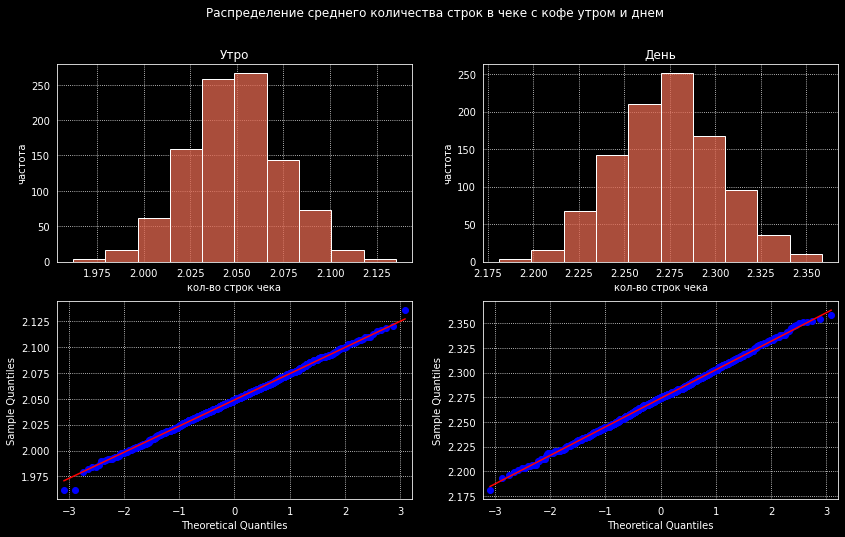

In [69]:
dist_evaluation(
    a3,
    b3,
    'Распределение среднего количества строк в чеке с кофе утром и днем',
    'Утро',
    'День'
)

Распределение средних в выборках после сэмплирования выглядит близко к нормальном. Возможно применение Т теста в модификации Уэлча, с параметром разности дисперсий, после проверки их тестом Левне.

In [70]:
# Проверка равенства дисперсий тестом Левене
levene_test(morning_coffee_lines['ItemsNo'], afternoon_coffee_lines['ItemsNo'], 0.05)

p-значение: 2.2943074543600556e-38
Необходимо отвергнуть нулевую гипотезу о равенстве дисперсий популяций из которых взяты выборки


Тест на эквивалентность дисперсий опять показал статистические различия, поэтому Т тест в этом случае будет также с параметром qual_var=False

In [71]:
# Проверка гипотезы Т тестом для выборок с разной дисперсией
t_test(morning_coffee_lines['ItemsNo'], afternoon_coffee_lines['ItemsNo'], 0.05)

p-значение: 1.194160338308203e-220
Необходимо отвергнуть нулевую гипотезу


In [72]:
# Проверка гипотезы тестом Манна-Уитни
test_mw(morning_coffee_lines['ItemsNo'], afternoon_coffee_lines['ItemsNo'], 0.05)

p-значение: 6.197219842784843e-247
Необходимо отвергнуть нулевую гипотезу


  0%|          | 0/1000 [00:00<?, ?it/s]

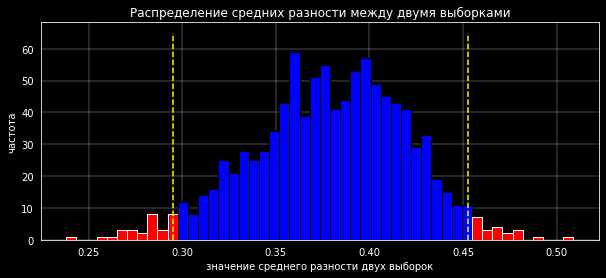


Вероятность попадания среднего разностей двух выборок в доверительный интервал при верной H0: 2.039094451218498e-20 

Необходимо отвергнуть нулевую гипотезу 

Границы доверительного интервала среднего разностей двух выборок               0
0.025  0.295278
0.975  0.452575 

Среднее разностей значений в исследуемой выборке 0.3804189369026094


In [73]:
# Проверка гипотезы бутстрепом
get_bootstrap(
    afternoon_coffee_lines['ItemsNo'], # числовые значения второй выборки
    morning_coffee_lines['ItemsNo'], # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # расчитываемая статистика
    bootstrap_conf_level = 0.95,
    alpha = 0.05 # уровень значимости
)

Вывод: оба статистических теста и бутстрапирование показали сильные статистические различия между средними количества чеков с кофе утром и днем. Днем покупая кофе люди берут другие позиции ассортимента в большем разнообразии чем утром.

## Общий вывод

<br>В представленной выборке данные только по утренним и дневным часам наиболее полны по дням. Поэтому анализировались эти временные отрезки.
<br>В половине дней работы заведения покупателей от 46 до 68, хотя есть пики - более 100 посетителей. Меньше 23 посетителей в выборочный период не было
<br>Днем приходит на 20% больше посетителей чем утром, до 8 утра совсем немного народу, в основном покупают с 9 и больше всего посетителей с 11 до 12 утра, но в целом с полудня и до 16 часов количество посетителей более стабильное. Время с 9 до 16 - самое активное для заведения, за этими рамками покупателей почти нет.
<br>На кофе и хлеб приходится 40% продаж, причем только на кофе - почти четверть 24%, остальные позиции покупают редко.
<br>Днем одну позицию заказывают на 5% меньше, зато увеличивается количество чеков с числом линий больше 3.
<br>Если есть в чеке кофе то днем число чеков с 3 и более линиями больше.
<br>Таким образом основные факторы влияющие на количество линий в чеке - время покупки и наличие якорного товара в чеке - кофе. Для увеличения длинны чека необходимо стимулировать покупку кофе в утренние часы,особенно в пиковый час с 11 до 12, обеспечить полноту и наличие остального ассортимента, быстроту обслуживания. Весь ассортимент также должен быть доступен с 12 до 16, возможно простимулировать покупку дополнительных позиций в это время, количества в линии чека по каждой позиции сопутствующего кофе ассортимента.